In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from astral import LocationInfo
from astral.sun import sun

blue = pd.read_csv("zurich_meteoblue_raw.csv",
                   parse_dates = ['time'], 
                   index_col = ['time'])

pi_data = pd.read_csv("airdata_raw.csv",
                 parse_dates = ['time'],
                 index_col = ['time'])

blue.rename(columns={"rel_humidity": "hum"}, inplace = True)

#remove NaN and extreme negative outlier for temp
pi_data.loc[pi_data['temp'] < -10] = np.nan
pi_data = pi_data.dropna() 

print(pi_data.isna().sum())
pi_data.describe()

id       0
temp     0
hum      0
PM1      0
PM2.5    0
PM10     0
dtype: int64


,id,temp,hum,PM1,PM2.5,PM10
count,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000
mean,3092.856935,10.646334,51.192911,4.694952,9.128555,13.678555
std,1784.098840,6.961464,14.925519,4.163538,7.024335,10.919859
min,1.000000,0.000000,17.300000,0.670000,0.740000,0.740000
25%,1548.500000,4.900000,39.700000,2.380000,4.430000,6.220000
50%,3093.000000,9.300000,51.700000,4.040000,7.740000,11.300000
75%,4637.500000,15.000000,62.550000,6.060000,12.190000,18.810000
max,6182.000000,32.400000,83.200000,190.930000,232.390000,257.730000


In [2]:
city = LocationInfo("Zurich", "Switzerland", "Europe/Zurich", 47.377, 8.542)

print((
    f"Information for {city.name}/{city.region}\n"
    f"Timezone: {city.timezone}\n"
    f"Latitude: {city.latitude:.02f}; Longitude: {city.longitude:.02f}\n"
))

sunrise = []
sunset = []

# setting range for months of march, april
for i in range(3,5):
    if i == 3:
        for j in range(1,32): #month length is different, need to change index range
            s = sun(city.observer, date=datetime.date(2021, i, j), tzinfo=city.timezone)
            sunrise.append(s["sunrise"]) 
            sunset.append(s["sunset"])
    else:
        for j in range(1,31): #month length is different, need to change index range
            s = sun(city.observer, date=datetime.date(2021, i, j), tzinfo=city.timezone)
            sunrise.append(s["sunrise"]) 
            sunset.append(s["sunset"])        
    
sunrise = pd.to_datetime(sunrise)
sunset = pd.to_datetime(sunset)

sun_data = pd.DataFrame({'sunrise':sunrise, 'sunset':sunset}) 
sun_data['day_len'] = sun_data['sunset'] - sun_data['sunrise']
sun_data['date'] = sun_data['sunrise'].dt.date

Information for Zurich/Switzerland
Timezone: Europe/Zurich
Latitude: 47.38; Longitude: 8.54



In [3]:
rng = pd.date_range("2021-03-18", "2021-04-12", freq="h")

In [4]:
sensor_sampled = pi_data.resample('h').mean() #resampling data frame for each hour

#update indexes to same timezone
sensor_sampled.index = sensor_sampled.index.tz_convert("Europe/Zurich")
blue.index = blue.index.tz_localize("Europe/Zurich", nonexistent = 'shift_forward')

In [5]:
#merge sensor and meteoblue data
sensor_blue_merge = pd.merge_ordered(sensor_sampled, blue, on = 'time', suffixes=('_pi', '_blue'), how='inner')
sensor_blue_merge['date'] = sensor_blue_merge['time'].dt.date

In [6]:
#add sunrise/sunset times
df_all = pd.merge_ordered(sensor_blue_merge, sun_data, on = 'date', how='inner', fill_method = 'ffill')
df_all.set_index('time', inplace = True)
df_all.drop('id', axis = 'columns', inplace = True)

In [10]:
df_all.head()
#export sampled file to CSV9
df_all.to_csv('1h_sampled_data.csv', index=True)

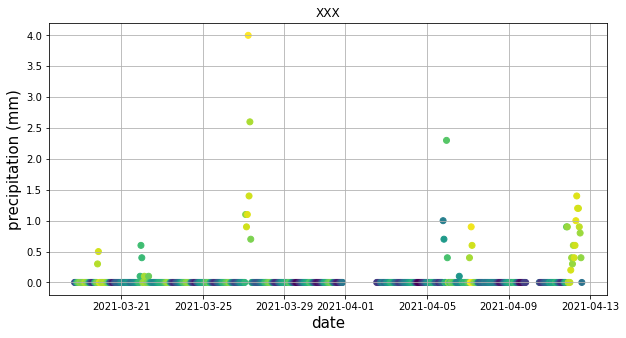

In [8]:
fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(df_all.index,df_all["precip"],c = df_all["hum_pi"])

ax.set_xlabel('date', fontsize=15)
ax.set_ylabel('precipitation (mm)', fontsize=15)
ax.set_title('XXX')

ax.grid(True)

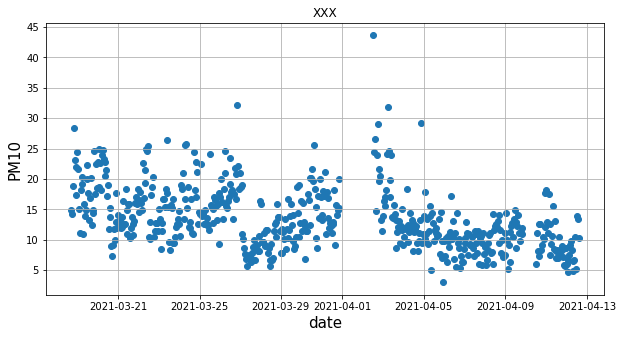

In [9]:
fig, ax = plt.subplots(figsize = (10,5))
plt.scatter(df_all.index,df_all["PM10"])

ax.set_xlabel('date', fontsize=15)
ax.set_ylabel('PM10', fontsize=15)
ax.set_title('XXX')

ax.grid(True)